In [2]:
import pennylane as qml
from pennylane import numpy as np
import networkx as nx
import scipy

np.random.seed(42)

In [3]:
## ALL USER INPUTS ## 

edges = [(0,1,0.7),(2,3,5),(3,0,4.5), (2,0,2.2), (0,3,2.5)] # Input the graph here. Coming up next: random graph generator?

## ADVANCED USER INPUTS ##
# For those familiar with the algorithm - if you want to tweak any hyperparameters ;)

num_layers = 4 # The number of layers to repeat our cost and mixer unitaries
num_reps = 100 # The number of repetitions of the circuit when sampling probability distribution. AKA the number of shots.
num_iters = 100 # The number of iterations our optimizer will go through when optimizing parameters
init_params = 0.01 * np.random.rand(2, num_layers) # Initialize the parameters near zero. Generates array size 2, 4. 

In [4]:
nodes = []
for edge in edges:
    start_node = edge[0]
    end_node = edge[1]
    if (start_node not in nodes):
        nodes.append(start_node)
    if (end_node not in nodes):
        nodes.append(end_node)
num_nodes = len(nodes)
print(num_nodes)

4


{(0, 1): Text(0.5073598498836595, 0.4174873431467674, '0.7'),
 (0, 3): Text(-0.317498175808859, -0.10080970843869018, '2.5'),
 (0, 2): Text(-0.17514197430748168, -0.3016719523281225, '2.2'),
 (2, 3): Text(-0.5073598498836595, -0.4174873431467673, '5')}

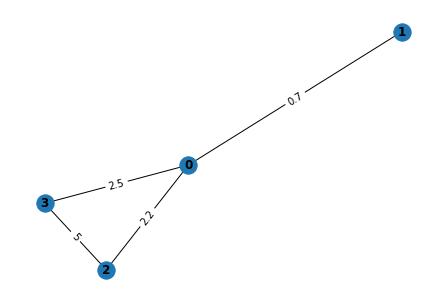

In [6]:
graph = nx.Graph() 
graph.add_nodes_from(nodes)
graph.add_weighted_edges_from(edges)

pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels = True, font_weight = 'bold')
labels = nx.get_edge_attributes(graph, 'weight')
nx.draw_networkx_edge_labels(graph, pos, edge_labels = labels)
#plt.savefig("graph-weighted.png")

In [7]:
# Mixer layer with parameter beta
def mixer_layer(beta):
    for wire in range(num_nodes):
        qml.RX(2 * beta, wires=wire)

# Cost layer with parameter gamma
def cost_layer(gamma):
    for edge in edges:
        wire1 = edge[0]
        wire2 = edge[1]
        weight = edge[2]
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(gamma*weight, wires=wire2) # Multiply gamma by the weight - this is the first algorithmetic change from the unweighted maxcut code
        qml.CNOT(wires=[wire1, wire2])

In [8]:
# Defining a function to measure all qubits in the computational basis, because Pennylane doesn't seem to have one.
def comp_basis_measurement(wires):
    num_nodes = len(wires)
    return qml.Hermitian(np.diag(range(2 ** num_nodes)), wires=wires)

In [9]:
dev = qml.device("default.qubit", wires=num_nodes, analytic=True, shots=1)

DeviceError: The analytic argument has been replaced by shots=None. Please use shots=None instead of analytic=True.

In [8]:
# Write a function that calculates the number of edges shared between the partitions of the graph.
def maxcut_obj(x, G):
    """
    Given a bitstring x and a graph G, return the number of edges shared between the paritions of the graph (objective).

    Parameters
    ----------
    x: str
        Test solution bitstring.
    G: networkx.classes.graph.Graph
        Input graph state.
    Returns
    -------
    out: int
        Objective.
    """
    out = 0
    for i,j in G.edges():
        out -= 1*(x[i] != x[j]) # Negative because we want to minimise the expectation value.
    return out

# Write a function that calculate the expectation value of the maxcut objective.
def expectation_maxcut_obj(counts, G):
    """
    Given a graph G and the resulting occurrences of different bitstrings, calculate and return the expectation value of the maxcut objective.

    Parameters
    ----------
    counts: dict
        Key as bitstring, val as count as the corresponding bitstrings.
    G: networkx.classes.graph.Graph
        Input graph state.
    
    Returns
    -------
    out: float
        Expectation value of the maxcut objective.
    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = maxcut_obj(bitstring, G)
        avg += obj*count
        sum_count += count
    out = avg/sum_count
    return out

In [9]:
def get_expectation(G, p , shots=512):
    backend = BasicAer.get_backend('qasm_simulator')
    def execute_circ(theta):
        qc = generate_QAOA_circuit(p, theta)
        counts = execute(qc,backend,shots=shots).result().get_counts()
        return expectation_maxcut_obj(counts, G)
    return execute_circ

In [10]:
# Minimise the expectation value of the maxcut objective using scipy's classical minimisation function.
p = 2
f_min = get_expectation(G, p=p, shots=4096) # function to minimise using a classical minimisation technique.
theta_guess = [1.0, 1.0] # initial guess values for beta and gamma.
out = minimize(f_min, theta_guess, method='COBYLA')
print(f"{out}")

     fun: -4.49267578125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([1.96439457, 1.19946836])


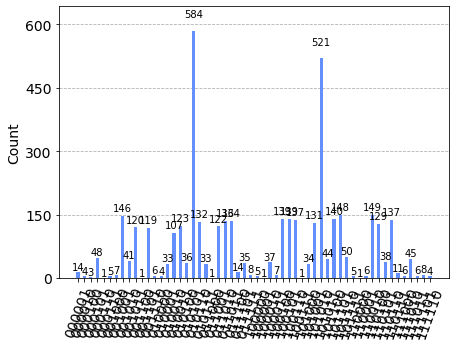

In [11]:
# Visualise the result from the classical minimisation.
backend = BasicAer.get_backend('qasm_simulator')

qc_res = generate_QAOA_circuit(p, out.x)

counts = execute(qc_res,backend,shots=4096).result().get_counts()

plot_histogram(counts)

In [12]:
# Sorting highest to lowest bitstring occurrences.
dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))

{'010101': 584,
 '101010': 521,
 '110010': 149,
 '101101': 148,
 '001001': 146,
 '101100': 140,
 '100100': 139,
 '100101': 139,
 '100110': 137,
 '110110': 137,
 '011010': 136,
 '011011': 134,
 '010110': 132,
 '101001': 131,
 '110100': 129,
 '010011': 123,
 '011001': 122,
 '001011': 120,
 '001101': 119,
 '010010': 107,
 '101110': 50,
 '000101': 48,
 '111010': 45,
 '101011': 44,
 '001010': 41,
 '110101': 38,
 '100010': 37,
 '010100': 36,
 '011101': 35,
 '101000': 34,
 '010001': 33,
 '010111': 33,
 '000001': 14,
 '011100': 14,
 '110111': 11,
 '111101': 8,
 '011111': 8,
 '001000': 7,
 '100011': 7,
 '111011': 6,
 '111000': 6,
 '001110': 6,
 '110001': 6,
 '101111': 5,
 '000111': 5,
 '100000': 5,
 '111110': 4,
 '010000': 4,
 '000010': 4,
 '000100': 3,
 '011000': 1,
 '001100': 1,
 '100111': 1,
 '100001': 1,
 '000110': 1,
 '110000': 1}